<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Introduction_to_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent neural networks

In this notebook, we will look at the fundamental concepts underlying Recurrent Neural Networks (RNN).

## Recurrent neurons

Up to now we have studied feedforward neural networks, where the activations flow only in one direction, from the input layer to the output layer. A recurrent neural network looks like a feedforward neural network, except it also has connections pointing backward. Let’s look at the simplest possible RNN, composed of just one neuron receiving inputs, producing an output, and sending that output back to itself, as shown in Figure 4-1 (left). At each time step $t$ (also called a *frame*), this recurrent neuron receives the inputs $x_{(t)}$ as well as its own output from the previous time step, $y_{(t–1)}$. Since there is no previous output at the first time step, it is generally set to 0. We can represent this tiny network against the time axis, as shown in Figure 4-1 (right). This is called unrolling the network through time (it’s the same recurrent neuron represented once per time step).

![texto alternativo](https://i.ibb.co/g7ByFbG/recurrent-neuron.png)


We can easily create a layer of recurrent neurons. At each time step $t$, every neuron receives both the input vector $\boldsymbol{x}_{(t)}$ and the output vector from the previous time step $\boldsymbol{y}_{(t–1)}$, as shown in Figure 4-2. Note that both the inputs and outputs are vectors now (when there was just a single neuron, the output was a scalar).

![texto alternativo](https://i.ibb.co/BNC0jRK/recurrent-layer.png)

Each recurrent neuron has two sets of weights: one for the inputs $\boldsymbol{x}_{(t)}$ and the other for the outputs of the previous time step, $\boldsymbol{y}_{(t–1)}$. Let’s call these weight vectors $\boldsymbol{w}_x$ and $\boldsymbol{w}_y$. If we consider the whole recurrent layer instead of just one recurrent neuron, we can place all the weight vectors in two weight matrices, $\boldsymbol{W}_x$ and $\boldsymbol{W}_y$. The output vector of the whole recurrent layer can then be computed pretty much as we might expect, as shown in the next equation.

$$\boldsymbol{y}_{(t)} = \phi(\boldsymbol{W}_x^T\boldsymbol{x}_{(t)}+\boldsymbol{W}_y^T\boldsymbol{y}_{(t-1)}+\boldsymbol{b})$$

where $\boldsymbol{b}$ is the bias vector and $ \phi(·)$ is the activation function.

Just like for feedforward neural networks, we can compute a recurrent layer’s output in one shot for a whole mini-batch by placing all the inputs at time step $t$ in an input matrix $\boldsymbol{X}_{(t)}$.

$$\boldsymbol{Y}_{(t)} = \phi(\boldsymbol{X}_{(t)}\boldsymbol{W}_x+\boldsymbol{Y}_{(t-1)}\boldsymbol{W}_y+\boldsymbol{b}) = \phi([\boldsymbol{X}_{(t)}\boldsymbol{Y}_{(t-1)}]\boldsymbol{W}+\boldsymbol{b}) \text{ where }\boldsymbol{W}=
\begin{pmatrix}
\boldsymbol{W}_x \\
\boldsymbol{W}_y
\end{pmatrix}
$$

- $\boldsymbol{Y}_{(t)}$ is an $m$ × $n$ matrix containing the layer’s outputs at time step $t$ for each instance in the mini-batch ($m$ is the number of instances in the mini-batch and $n$ is the number of neurons).

- $\boldsymbol{X}_{(t)}$  is an $m$ × $p$ matrix containing the inputs for all instances ($p$ is the number of input features).

- $\boldsymbol{W}_x $ is an $p$ × $n$ matrix containing the connection weights for the inputs of the current time step.

- $\boldsymbol{W}_y $ is an $n$ × $n$ matrix containing the connection weights for the outputs of the current time step.

- $\boldsymbol{b}$ is a vector of size $n$ containing each neuron’s bias term.

- The weight matrices $\boldsymbol{W}_x$ and $\boldsymbol{W}_y$ are often concatenated vertically into a single weight matrix $\boldsymbol{W}$ of shape ($p$ + $n$) × $n$.

- The notation $[\boldsymbol{X}_{(t)}\boldsymbol{Y}_{(t-1)}]$ represents the horizontal concatenation of the matrices $\boldsymbol{X}_{(t)}$ and $\boldsymbol{Y}_{(t-1)}$.

Notice that $\boldsymbol{Y}_{(t)}$ is a function of $\boldsymbol{X}_{(t)}$ and $\boldsymbol{Y}_{(t-1)}$, which is a function of $\boldsymbol{X}_{(t-1)}$ and $\boldsymbol{Y}_{(t-2)}$, which is a function of $\boldsymbol{X}_{(t-2)}$ and $\boldsymbol{Y}_{(t-3)}$, and so on. This makes $\boldsymbol{Y}_{(t)}$ a function of all the inputs since time $t = 0$ (that is, $\boldsymbol{X}_{(0)},\boldsymbol{X}_{(1)},...,\boldsymbol{X}_{(t)}$). At the first time step, $t = 0$, there are no previous outputs, so they are typically assumed to be all zeros.


### Memory cells



Since the output of a recurrent neuron at time step $t$ is a function of all the inputs from previous time steps, we could say it has a form of *memory*. A part of a neural network that preserves some state across time steps is called a *memory cell* (or simply a *cell*). A single recurrent neuron, or a layer of recurrent neurons, is a very basic cell, capable of learning only short patterns (typically about 10 steps long, but this varies depending on the task). Later, we will look at some more complex and powerful types of cells capable of learning longer patterns (roughly 10 times longer, but again, this depends on the task).

In general a cell’s state at time step $t$, denoted $\boldsymbol{h}_{(t)}$ (the “h” stands for “hidden”), is a function of some inputs at that time step and its state at the previous time step: $\boldsymbol{h}_{(t)}=f(\boldsymbol{h}_{(t-1)},\boldsymbol{x}_{(t)})$. Its output at time step $t$, denoted $\boldsymbol{y}_{(t)}$, is also a function of the previous state and the current inputs. In the case of the basic cells we have discussed so far, the output is simply equal to the state, but in more complex cells this is not always the case, as shown in Figure 4-3.

![texto alternativo](https://i.ibb.co/WgpyWBm/hidden-cells.png)

### Input and Output Sequences

An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs (see Figure 4-4, top-left network). For example, this type of network (*sequence-to-sequence network*) is useful for predicting time series such as stock prices: we feed it the prices over the last $N$ days, and it must output the prices shifted by one day into the future (i.e., from $N – 1$ days ago to tomorrow).

Alternatively, we could feed the network a sequence of inputs, and ignore all outputs except for the last one (see the top-right network). In other words, this is a *sequence-to-vector network*. For example, we could feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., from –1 (hate) to +1 (love)).

Conversely, we could feed the network a single input at the first time step (and zeros for all other time steps), and let it output a sequence (see the bottom-left network). This is a *vector-to-sequence network*. For example, the input could be an image, and the output could be a caption for that image.

Lastly, we could have a sequence-to-vector network, called an *encoder*, followed by a vector-to-sequence network, called a *decoder* (see the bottom-right network). For example, this can be used for translating a sentence from one language to another. We would feed the network a sentence in one language, the encoder would convert this sentence into a single vector representation, and then the decoder would decode this vector into a sentence in another language. This two-step model, called an *Encoder–Decoder*, works much better than trying to translate on the fly with a single sequence-to-sequence RNN (like the one represented on the top left), since the last words of a sentence can affect the first words of the translation, so we need to wait until we have heard the whole sentence before translating it.

![texto alternativo](https://i.ibb.co/b5NpXXV/inputs-outputs-rnn.png)

### Basic RNNs in TensorFlow

Let’s implement a very simple RNN model, without using any of Keras RNN operations or layers, to better understand what goes on under the hood. We will create an RNN composed of a layer of five recurrent neurons (like the RNN represented in Figure 4-2), using the tanh activation function. We will assume that the RNN runs over only two time steps, taking input vectors of size 3 at each time step. The following code builds this RNN, unrolled through two time steps:


In [1]:
# %tensorflow_version only exists in Colab.
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np


number_inputs, number_neurons = 3, 5

Wx = tf.Variable(tf.random.normal(shape=[number_inputs, number_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random.normal(shape=[number_neurons,number_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, number_neurons], dtype=tf.float32))

# This mini-batch contains four instances, each with an input sequence composed of exactly two inputs.
X0_batch = tf.constant([[2,0,1], [3,4,5], [6,7,8], [3,4,6]], dtype=tf.float32) # t = 0
X1_batch = tf.constant([[5,6,9], [0,0,0], [3,4,6], [2,0,1]], dtype=tf.float32) # t = 1

# the outputs of the network at both time steps for all neurons and all instances in the mini-batch:
Y0 = tf.tanh(tf.matmul(X0_batch,Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0,Wy) + tf.matmul(X1_batch,Wx) + b)
print(Y0)
print(Y1)



tf.Tensor(
[[ 0.98501414 -0.7666322   0.54267424 -0.9328237   0.8548549 ]
 [ 0.999637   -0.9967076  -0.99352276 -0.7360313   0.9999997 ]
 [ 1.         -0.99917793 -0.9983607  -0.9929374   1.        ]
 [ 0.9995053  -0.9999195  -0.99927354 -0.42913193  1.        ]], shape=(4, 5), dtype=float32)
tf.Tensor(
[[ 1.         -0.9999997  -0.9905623  -0.9591707   1.        ]
 [ 0.5848055   0.6233743   0.9987169   0.81161284  0.863321  ]
 [ 0.99996156 -0.99945575 -0.41208363  0.5552714   1.        ]
 [ 0.98296666 -0.492799    0.9997403  -0.44557783  0.9950033 ]], shape=(4, 5), dtype=float32)


This network looks much like a two-layer feedforward neural network, with a few twists: first, the same weights and bias terms are shared by both layers, and second, we feed inputs at each layer, and we get outputs from each layer.

Of course if we want to be able to run an RNN over 100 time steps, the graph is going to be pretty big. Now let’s look at how to create the same model using Keras RNN layers.


In [2]:
import tensorflow.keras as keras

X_batch = np.array([[[2,0,1], [3,4,5], [6,7,8], [3,4,6]],
                    [[5,6,9], [0,0,0], [3,4,6], [2,0,1]]]).astype(np.float32)

simple_rnn = keras.layers.SimpleRNN(number_neurons, return_sequences=True)

whole_sequence_output = simple_rnn(X_batch)
YO,Y1 = whole_sequence_output
print(Y0)
print(Y1)

tf.Tensor(
[[ 0.98501414 -0.7666322   0.54267424 -0.9328237   0.8548549 ]
 [ 0.999637   -0.9967076  -0.99352276 -0.7360313   0.9999997 ]
 [ 1.         -0.99917793 -0.9983607  -0.9929374   1.        ]
 [ 0.9995053  -0.9999195  -0.99927354 -0.42913193  1.        ]], shape=(4, 5), dtype=float32)
tf.Tensor(
[[ 0.98623425 -0.90092033  0.99930525  1.          0.9892836 ]
 [-0.8272909   0.32941952 -0.561485   -0.88602525 -0.73466974]
 [ 0.9807148  -0.91338706  0.995859    0.99999803  0.9798452 ]
 [-0.9371917   0.88901293  0.04675839  0.4145025  -0.35458684]], shape=(4, 5), dtype=float32)


The `simple_rnn` function returns two objects. The first is a Python list containing the output tensors for each time step. The second is a tensor containing the final states of the network. When we are using basic cells, the final state is simply equal to the last output.

## Training RNNs

To train an RNN, the trick is to unroll it through time (like we just did) and then simply use regular backpropagation (see Figure 15-5). This strategy is called *backpropagation through time* (BPTT).

Just like in regular backpropagation, there is a first forward pass through the unrolled network (represented by the dashed arrows). Then the output sequence is evaluated using a cost function $C(\boldsymbol{Y}_{(0)}, \boldsymbol{Y}_{(1)},...,\boldsymbol{Y}_{(T)})$ (where $T$ is the max time step). Note that this cost function may ignore some outputs, as shown in Figure 15-5 (for example, in a sequence-to-vector RNN, all outputs are ignored except for the very last one). The gradients of that cost function are then propagated backward through the unrolled network (represented by the solid arrows). Finally the model parameters are updated using the gradients computed during BPTT. Note that the gradients flow backward through all the outputs used by the cost function, not just through the final output (for example, in Figure 15-5 the cost function is computed using the last three outputs of the network, $\boldsymbol{Y}_{(2)}, \boldsymbol{Y}_{(3)}$ and $\boldsymbol{Y}_{(4)}$, so gradients flow through these three outputs, but not through $\boldsymbol{Y}_{(0)}$ and $\boldsymbol{Y}_{(1)}$). Moreover, since the same parameters $\boldsymbol{W}$ and $\boldsymbol{b}$ are used at each time step, backpropagation will do the right thing and sum over all time steps.

![texto alternativo](https://i.ibb.co/kKM7VpZ/BPTT.png)

Fortunately, `tf.keras` takes care of all of this complexity.

## Forecasting a Time Series

Suppose we are studying the number of active users per hour on our website, or our company’s financial health, measured quarterly using multiple metrics. In both cases, the data will be a sequence of one or more values per time step. This is called a *time series*. In the first example there is a single value per time step, so it is a *univariate time series*, while in the financial example there are multiple values per time step (e.g., the company’s revenue, debt, and so on), so it is a *multivariate time series*. A typical task is to predict future values, which is called *forecasting*. 

For example, we are using a time series generated by the `generate_time_series()` function, shown here:

In [3]:
import tensorflow as tf
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

This function creates as many time series as requested (via the `batch_size` argument), each of length `n_steps`, and there is just one value per time step in each series (i.e., all series are univariate). The function returns a NumPy array of shape `[batch size, time steps, 1]`, where each series is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise.

- Observation: When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape `[batch size, time steps, dimensionality]`, where dimensionality is 1 for univariate time series and more for multivariate time series.

Now let’s create a training set, a validation set, and a test set using this function:



In [4]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
print(f'Shape of dataset: {series.shape}')
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of y_valid: {y_valid.shape}')
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of dataset: (10000, 51, 1)
Shape of X_train: (7000, 50, 1)
Shape of y_train: (7000, 1)
Shape of X_valid: (2000, 50, 1)
Shape of y_valid: (2000, 1)
Shape of X_test: (1000, 50, 1)
Shape of y_test: (1000, 1)



`X_train` contains 7,000 time series (i.e., its shape is `[7000, 50, 1]`), while `X_valid` contains 2,000 (from the 7,000th time series to the 8,999th) and `X_test` contains 1,000 (from the 9,000th to the 9,999th). Since we want to forecast a single value for each series, the targets are column vectors (e.g., `y_train` has a shape of `[7000, 1]`).

For example, the next code plot 3 univariate time series, each of them 50 time steps long, and the goal here is to forecast the value at the next time step (represented by the X) for each of them.

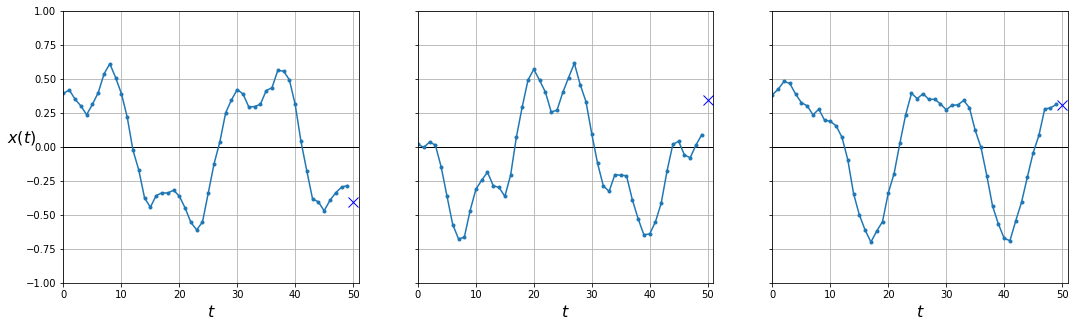

In [5]:
import matplotlib.pyplot as plt
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### Baseline models

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models. For example, the simplest approach is to predict the last value in each series (*naive forecasting*). In this case, it gives us a mean squared error of about 0.020:

In [6]:
import keras
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020229913

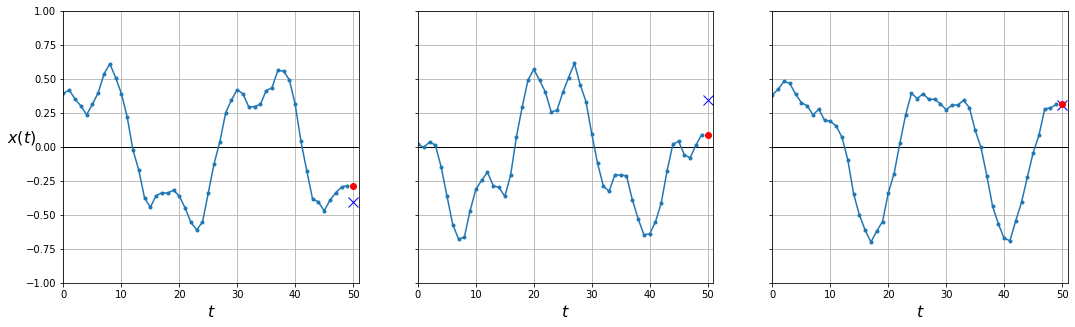

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5))
for i in range(3):
    plt.sca(axes[i])
    plot = plot_series(X_valid[i, :, 0], y_valid[i, 0], y_pred[i, 0],
                y_label=("$x(t)$" if i==0 else None))
                       
plt.show()

The red point is the value predicted by the model. The truth value is represented by the blue X.

Another simple aproach is to predict the next point to be the average of the last 50 observations. Another baseline approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a `Flatten` layer. Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [8]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

If we compile this model using the MSE loss and the default Adam optimizer, then fit it on the training set for 20 epochs and evaluate it on the validation set, we get an MSE of about 0.004. That’s much better than the naive approach!

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.0563
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0397 - val_loss: 0.0275
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0210 - val_loss: 0.0162
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0136 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0095
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0060

In [10]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 733us/step - loss: 0.0043


0.004347564186900854

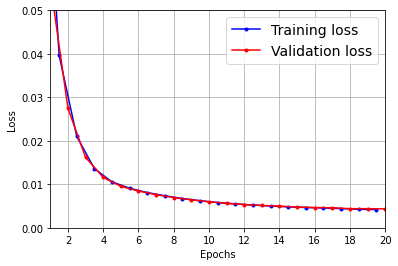

In [11]:
import matplotlib as mpl
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

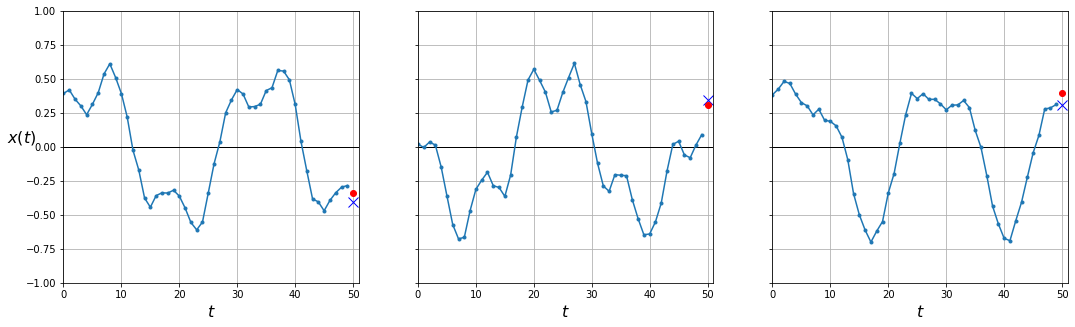

In [12]:
y_pred = model.predict(X_valid)
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5))
for i in range(3):
    plt.sca(axes[i])
    plot = plot_series(X_valid[i, :, 0], y_valid[i, 0], y_pred[i, 0],
                y_label=("$x(t)$" if i==0 else None))
                       
plt.show()

### Simple RNN

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

That’s the simplest RNN we can build. It just contains a single layer, with a single neuron, as we saw in Figure 4-1. We do not need to specify the length of the input sequences (unlike in the previous model), since a recurrent neural network can process any number of time steps (this is why we set the first input dimension to `None`). By default, the `SimpleRNN` layer uses the hyperbolic tangent activation function. It works exactly as we saw earlier: the initial state $h_{(init)}$ is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step, $x_{(0)}$. The neuron computes a weighted sum of these values and applies the hyperbolic tangent activation function to the result, and this gives the first output, $y_{(0)}$. In a simple RNN, this output is also the new state $h_{(0)}$. This new state is passed to the same recurrent neuron along with the next input value, $x_{(1)}$, and the process is repeated until the last time step. Then the layer just outputs the last value, $y_{(49)}$. All of this is performed simultaneously for every time series.

- Observation: by default, recurrent layers in Keras only return the final output. To make them return one output per time step, we must set `return_sequences=True`.

If we compile, fit, and evaluate this model (just like earlier, we train for 20 epochs using Adam), we find that its MSE reaches only 0.010, so it is better than the naive approach but it does not beat a simple linear model. Note that for each neuron, a linear model has one parameter per input and per time step, plus a bias term (in the simple linear model we used, that’s a total of 51 parameters). In contrast, for each recurrent neuron in a simple RNN, there is just one parameter per input and per hidden state dimension (in a simple RNN, that’s just the number of recurrent neurons in the layer), plus a bias term. In this simple RNN, that’s a total of just three parameters.

In [14]:
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0962 - val_loss: 0.0463
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0363 - val_loss: 0.0281
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0248 - val_loss: 0.0210
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0194 - val_loss: 0.0171
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0163 - val_loss: 0.0148
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0144 - val_loss: 0.0132
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0117 - val_loss: 0.0110

In [15]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0109


0.010868354700505733

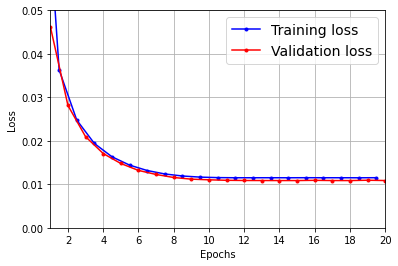

In [16]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

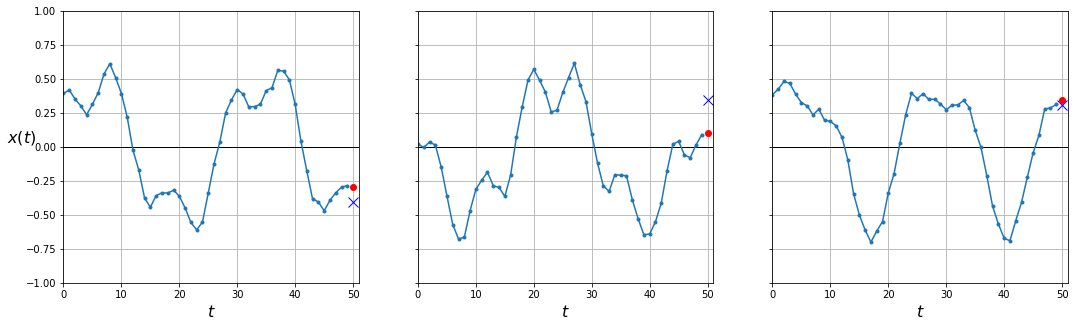

In [17]:
y_pred = model.predict(X_valid)
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5))
for i in range(3):
    plt.sca(axes[i])
    plot = plot_series(X_valid[i, :, 0], y_valid[i, 0], y_pred[i, 0],
                y_label=("$x(t)$" if i==0 else None))
                       
plt.show()

### Trend and seasonality 

There are many other models to forecast time series, such as *weighted moving average* models or *autoregressive integrated moving average* (ARIMA) models. Some of them require we to first remove the trend and seasonality. For example, if we are studying the number of active users on our website, and it is growing by 10% every month, we would have to remove this trend from the time series. Once the model is trained and starts making predictions, we would have to add the trend back to get the final predictions. Similarly, if we are trying to predict the amount of sunscreen lotion sold every month, we will probably observe strong seasonality: since it sells well every summer, a similar pattern will be repeated every year. We would have to remove this seasonality from the time series, for example by computing the difference between the value at each time step and the value one year earlier (this technique is called *differencing*). Again, after the model is trained and makes predictions, we would have to add the seasonal pattern back to get the final predictions.

When using RNNs, it is generally not necessary to do all this, but it may improve performance in some cases, since the model will not have to learn the trend or the seasonality.

### Deep RNNs

It is quite common to stack multiple layers of cells, as shown in Figure 15-7. This gives us a *deep* RNN.

![texto alternativo](https://i.ibb.co/fr4Zfss/deep-RNN.png)

Implementing a deep RNN with `tf.keras` is quite simple: just stack recurrent layers. In this example, we use three `SimpleRNN` layers (but we could add any other type of recurrent layer, such as an LSTM layer or a GRU layer, which we will discuss in next notebook):

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

Note that using a `SimpleRNN` layer in the last layer is not ideal: it must have a single unit because we want to forecast a univariate time series, and this means we must have a single output value per time step. However, having a single unit means that the hidden state is just a single number. That’s really not much, and it’s probably not that useful; presumably, the RNN will mostly use the hidden states of the other recurrent layers to carry over all the information it needs from time step to time step, and it will not use the final layer’s hidden state very much. Moreover, since a `SimpleRNN` layer uses the tanh activation function by default, the predicted values must lie within the range –1 to 1. But what if we want to use another activation function? For both these reasons, it might be preferable to replace the output layer with a `Dense` layer: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want. If we make this change, also make sure to remove `return_sequences=True` from the second (now last) recurrent layer.


In [19]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

**Note**: Make sure to set return_sequences=True for all recurrent layers (except the last one, if we only care about the last output). If we don’t, they will output a 2D array (containing only the output of the last time step) instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that we are not feeding it sequences in the expected 3D format.

If we compile, fit, and evaluate this model, we find that it reaches an MSE of 0.003. We finally managed to beat the linear model!

In [20]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0221 - val_loss: 0.0048
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 7/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 10/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0030 - val_lo

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0031


0.0030559010338038206

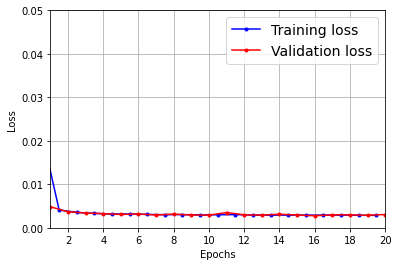

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

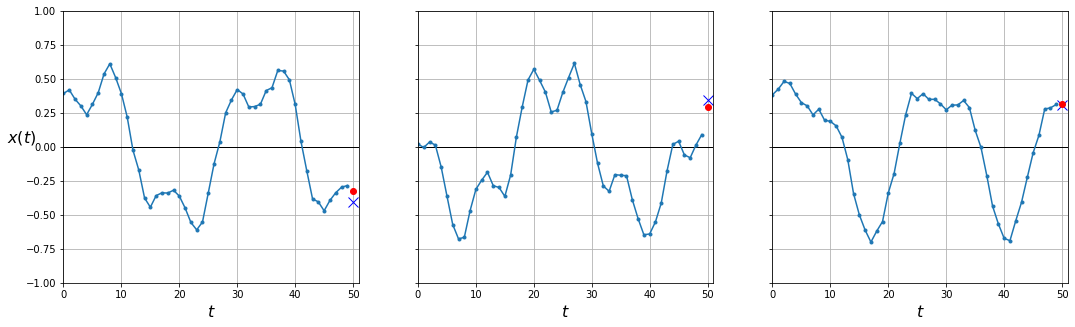

In [23]:
y_pred = model.predict(X_valid)
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(18, 5))
for i in range(3):
    plt.sca(axes[i])
    plot = plot_series(X_valid[i, :, 0], y_valid[i, 0], y_pred[i, 0],
                y_label=("$x(t)$" if i==0 else None))
                       
plt.show()

### Forecasting Several Time Steps Ahead

So far we have only predicted the value at the next time step.  But what if we want to predict the next 10 values?

The first option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occurred), and use the model again to predict the following value, and so on. But the prediction for the next step will usually be more accurate than the predictions for later time steps, since the errors might accumulate.



In [24]:

np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
print(Y_pred.shape)

(1, 10, 1)


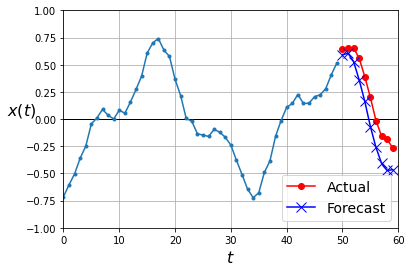

In [25]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

If we evaluate this approach on the validation set, we get an MSE of about 0.04. 

In [26]:
np.random.seed(42)
# Now let's use this model to predict the next 10 values.
# We first need to regenerate the sequences with 9 more time steps.

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
print(f'Shape of dataset: {series.shape}')
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {Y_train.shape}')
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of y_valid: {Y_valid.shape}')
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {Y_test.shape}')

Shape of dataset: (10000, 60, 1)
Shape of X_train: (7000, 50, 1)
Shape of y_train: (7000, 10)
Shape of X_valid: (2000, 50, 1)
Shape of y_valid: (2000, 10)
Shape of X_test: (1000, 50, 1)
Shape of y_test: (1000, 10)


In [27]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]
print(Y_pred.shape)
print(np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred)))

(2000, 10)
0.041359384


This is much higher than the previous models, but it’s also a much harder task, so the comparison doesn’t mean much. It’s much more meaningful to compare this performance with naive predictions (just forecasting that the time series will remain constant for 10 time steps) or with a simple linear model. 

In [28]:
Y_naive_pred = Y_valid[:, -1:]
print(np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred)))

0.22278848


The naive approach is terrible (it gives an MSE of about 0.223)

In [29]:
# Linear model
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0227 - val_loss: 0.0222

The linear model gives an MSE of about 0.0188: it’s much better than using our RNN to forecast the future one step at a time, and also much faster to train and run. Still, if we only want to forecast a few time steps ahead, on more complex tasks, this approach may work well.

The second option is to train an RNN to predict all 10 next values at once. We can still use a sequence-to-vector model, but it will output 10 values instead of 1. Note that we have already changed the targets to be vectors containing the next 10 values:

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10) # we just need the output layer to have 10 units instead of 1
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0110 - val_lo

After training this model, we can predict the next 10 values at once very easily:

In [31]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]


This model works nicely: the MSE for the next 10 time steps is about 0.008.

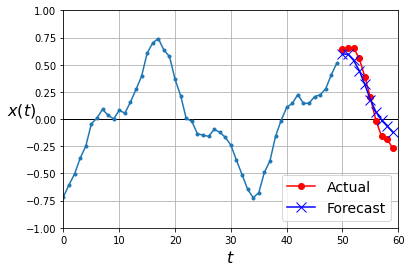

In [32]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

 

But we can still do better: instead of training the model to forecast the next 10 values only at the very last time step, we can train it to forecast the next 10 values at each and every time step. In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at the last time step. This means there will be many more error gradients flowing through the model, and they won’t have to flow only through time; they will also flow from the output of each time step. This will both stabilize and speed up training.

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. So each target must be a sequence of the same length as the input sequence, containing a 10-dimensional vector at each step. Let’s prepare these target sequences:

In [33]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
print(f'Shape of dataset: {series.shape}')
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    #Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {Y_train.shape}')
Y_valid = Y[7000:9000]
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of y_valid: {Y_valid.shape}')
Y_test = Y[9000:]
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {Y_test.shape}')

Shape of dataset: (10000, 60, 1)
Shape of X_train: (7000, 50, 1)
Shape of y_train: (7000, 50, 10)
Shape of X_valid: (2000, 50, 1)
Shape of y_valid: (2000, 50, 10)
Shape of X_test: (1000, 50, 1)
Shape of y_test: (1000, 50, 10)


**Note**: It may be surprising that the targets will contain values that appear in the inputs (there is a lot of overlap between `X_train` and `Y_train`). Isn’t that cheating? Fortunately, not at all: at each time step, the model only knows about past time steps, so it cannot look ahead. It is said to be a *causal* model.

To turn the model into a *sequence-to-sequence* model, we must set `return_sequences=True` in all recurrent layers (even the last one), and we must apply the output `Dense` layer at every time step. Keras offers a `TimeDistributed` layer for this purpose: it wraps any layer (e.g., a `Dense` layer) and applies it at every time step of its input sequence. It does this efficiently, by reshaping the inputs so that each time step is treated as a separate instance (i.e., it reshapes the inputs from [*batch size, time steps, input dimensions*] to [*batch size × time steps, input dimensions*]; in this example, the number of input dimensions is 20 because the previous `SimpleRNN` layer has 20 units), then it runs the `Dense` layer, and finally it reshapes the outputs back to sequences (i.e., it reshapes the outputs from [*batch size × time steps, output dimensions*] to [*batch size, time steps, output dimensions*]; in this example the number of output dimensions is 10, since the `Dense` layer has 10 units). Here is the updated model:

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

The `Dense` layer actually supports sequences as inputs (and even higher-dimensional inputs): it handles them just like `TimeDistributed`(`Dense`(…)), meaning it is applied to the last input dimension only (independently across all time steps). Thus, we could replace the last layer with just `Dense(10)`. For the sake of clarity, however, we will keep using `TimeDistributed(Dense(10))` because it makes it clear that the `Dense` layer is applied independently at each time step and that the model will output a sequence, not just a single vector.

All outputs are needed during training, but only the output at the last time step is useful for predictions and for evaluation. So although we will rely on the MSE over all the outputs for training, we will use a custom metric for evaluation, to only compute the MSE over the output at the last time step:

In [35]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))



Epoch 1/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0363 - val_last_time_step_mse: 0.0260
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0325 - last_time_step_mse: 0.0214 - val_loss: 0.0368 - val_last_time_step_mse: 0.0279
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0298 - last_time_step_mse: 0.0188 - val_loss: 0.0273 - val_last_time_step_mse: 0.0155
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0270 - last_time_step_mse: 0.0149 - val_loss: 0.0266 - val_last_time_step_mse: 0.0163
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0250 - last_time_step_mse: 0.0123 - val_loss: 0.0248 - val_last_time_step_mse: 0.0122
Epoch 7/20
219/219 [==

In [36]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

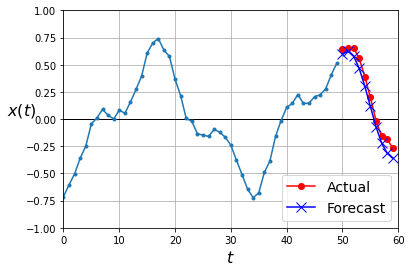

In [37]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

With this approach, we can generate arbitrarily long sequences. However, it may not be very accurate for long-term predictions.

**Note**: When forecasting time series, it is often useful to have some error bars along with our predictions. For this, an efficient technique is Monte Carlo Dropout (MC Dropout). An MC Dropout layer within each memory cell, dropping part of the inputs and hidden states. After training, to forecast a new time series, use the model many times and compute the mean and standard deviation of the predictions at each time step.

Simple RNNs can be quite good at forecasting time series or handling other kinds of sequences, but they do not perform as well on long time series or sequences. We will discuss why and see what we can do about it in a next notebook.

# References

- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

- https://github.com/ageron/handson-ml2

- [Time series forecasting TensorFlow](https://www.tensorflow.org/tutorials/structured_data/time_series)


- [Forecasting: Principles and Practice](https://otexts.com/fpp2/index.html)